<a href="https://colab.research.google.com/github/yufeng66/FutureGreeks/blob/master/AAA_scenario_25yr_put.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AAA scenario, future greek example

First, make sure GPU is avaiable.

In [0]:
!nvidia-smi

Wed Oct 16 19:28:35 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    73W / 149W |   2164MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Update to the latest pytorch packages

In [0]:
!pip3 install torch torchvision --upgrade

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.3.0)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.4.1)


Typical import and housekeeping

In [0]:
import torch
import numpy as np
from torch.autograd import grad
print("torch version: ", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

torch version:  1.3.0
cuda


##Scenario generator
The following block generate the US Diversified equity scenario. It follows the logic from 
Academy's Interest Rate Generator version 7.1.201805 which is download from [Society of Acturies](https://www.soa.org/resources/tables-calcs-tools/research-scenario/)


In [0]:
import math
@torch.jit.script
def aaa_us(N:int=10000, T:int=360, sigma_0:float=0.1476, device:str="cuda"):

  """
    return us equity scenario, following the AAA logic
    N is scenario number, 
    T is the number of month
    sigma_0 is the initial vol, default to AAA US Diversified Equity
    All other parameters below are for US Diversified Equity and
    copied from Academy's Interest Rate Generator (AIRG) (Version 7.1.201805)
  """


  tau = 0.12515
  phi = 0.35229
  sigma_v =0.32645
  rho = -0.2488
  A = 0.055
  B = 0.56
  C = -0.9
  
  sigma_min = 0.0305
  sigma_max = 0.3
  sigma_max2 = 0.7988


  #cholesky decompsition
  corr=torch.eye(2,device=device)
  corr[0,1]=rho
  corr[1,0]=rho
  chl=torch.cholesky(corr)

  #correlated random number
  rdn=torch.randn(N,T,2,1,device=device)
  rdn=torch.matmul(chl,rdn)
  rdn=rdn.view(N,T,2)

  sigma=torch.ones(N,T+1,device=device)
  us=torch.ones(N,T+1,device=device)

  sigma[:,0]=sigma_0
  us[:,0]=1.0

  log_tau=math.log(tau)
  log_sigma_min=math.log(sigma_min)
  log_sigma_max=math.log(sigma_max)
  log_sigma_max2=math.log(sigma_max2)

  sqrt12=math.sqrt(12.0)
  for t in range(T):
    log_vol=torch.log(sigma[:,t])
    log_vol=(1-phi)*log_vol+phi*log_tau
    log_vol=torch.clamp(log_vol,max=log_sigma_max)
    log_vol=log_vol+rdn[:,t,0]*sigma_v
    log_vol=torch.clamp(log_vol,min=log_sigma_min,max=log_sigma_max2)
    sigma[:,t+1]=torch.exp(log_vol)
    mean_return=A+B*sigma[:,t+1]+C*sigma[:,t+1]*sigma[:,t+1]
    next_return=mean_return/12.0+rdn[:,t,1]*sigma[:,t+1]/sqrt12
    us[:,t+1]=us[:,t]*torch.exp(next_return)
  return us, sigma

Compare key statistics of the scenario generator with the original excel version

10 year point from original excel model 
avg ln=0.732818079,std ln=0.479882024
10 year point from pytorch model
avg ln= 0.7297905683517456 std ln= 0.47575047612190247
30 year point from original excel 
avg ln=2.196974867,std ln=0.825873276
30 year point from pytorch model
avg ln= 2.2024662494659424 std ln= 0.8309392929077148


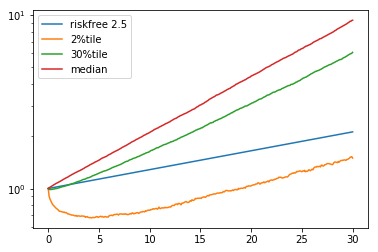

In [0]:
us, sigma = aaa_us()
log120=torch.log(us[:,120])
log360=torch.log(us[:,360])
print("10 year point from original excel model \navg ln=0.732818079,std ln=0.479882024")
print("10 year point from pytorch model")
print("avg ln=",log120.mean().item(),"std ln=",log120.std().item())
print("30 year point from original excel \navg ln=2.196974867,std ln=0.825873276")
print("30 year point from pytorch model")
print("avg ln=",log360.mean().item(),"std ln=",log360.std().item())

import matplotlib.pyplot as plt

us=us.to('cpu').numpy()
pct2=np.percentile(us,2,axis=0)
pct30=np.percentile(us,30,axis=0)
pct50=np.percentile(us,50,axis=0)

t2=torch.linspace(0,30,361).cpu().numpy()
rf2=np.exp(.025*t2)
plt.plot(t2,rf2,label='riskfree 2.5')
plt.plot(t2,pct2,label='2%tile')
plt.plot(t2,pct30,label='30%tile')
plt.plot(t2,pct50,label='median')


plt.yscale('log')
plt.legend()
plt.show()


This chart compares return of AAA scenario at median, 30 percentile and 2 percentile to risk free growth in log scale. We assume risk free rate is 2.5%

### Liability cashflow

The liability is a 25 year put with strike at 3, with the index starts at 1.

The growth rate to strike is the 4.5% per year.
It is higher than the risk free rate of 2.5%. But much lower compared to the AAA scenario median growth rate of 8%.

In [0]:
def cashflow_1(scenario):
  """
    cash flow module for a put
  """
  strike = 3.
  payout = torch.clamp(strike-scenario[:,-1],min=0.0)
  cf=torch.zeros_like(scenario)
  cf[:,-1].add_(payout)
  return cf


Generate scenario and cashflow

In [0]:
K1, K2 = 3, 10
N1=2**K1   #batch count
N2=2**K2   #batch size

T=300
rf=0.025

idx,sigma=aaa_us(N=N1*N2,T=T)

cf=cashflow_1(idx)

idx=idx.view(N1,N2,T+1)
sigma=sigma.view(N1,N2,T+1)
cf=cf.view(N1,N2,T+1)

t=torch.linspace(0,T/12,T+1,device=device)
disc=torch.exp(-rf*t)
disc=disc.repeat(N1,N2,1)

pv_payout=cf[:,:,-1]*disc[:,:,-1]

#the chg is discounted to time zero already
chg=idx[:,:,1:]*disc[:,:,1:]-idx[:,:,:-1]*disc[:,:,:-1]

# chg2 is the second order discounted to time zero    
chg2=torch.log(idx[:,:,1:]/idx[:,:,:-1])**2-((sigma[:,:,1:])**2)/12
chg2=chg2*disc[:,:,1:]

Manipulate data to feed to the neural network. 

In [0]:
t=torch.linspace(T/12,1/12,T,device=device)  #time to maturity
t=t.repeat(N1,N2,1)
s=idx[:,:,:-1].view(N1,N2,T,1)
s.requires_grad=True
v=sigma[:,:,:-1].view(N1,N2,T,1)
t=t.view(N1,N2,T,1)
tsv=torch.cat((t,s,v),3)

Calculate the effective volatility of the scenarios at year 25

In [0]:
vol=torch.log(idx[:,:,-1]).std().cpu().item()
vol=vol/math.sqrt(25) 
#this is the effective volatility of the scenario at year 25

Release memory by delete object

In [0]:


#delete objects to release memory
del t
del v
del idx
del sigma


The neural network. we have three input: time to maturity, index level and the short term volatility from AAA scenario generator

In [0]:
model_delta = torch.nn.Sequential(
    torch.nn.Linear(3, 24),
    torch.nn.Tanh(),
    torch.nn.Linear(24,12),
    torch.nn.Tanh(),
    torch.nn.Linear(12, 1),
    torch.nn.Sigmoid(),
)
model_delta = model_delta.to(device)

First we train with AdamW optimizer to warm up

The time step for AAA scenario is monthly. It is not sufficient for delta hedge. We use the gamma and expected volatility to approximate the result of daily rebalancing delta hedge. 

In [0]:
import time
optimizer = torch.optim.AdamW(model_delta.parameters(),lr=0.03,
                              weight_decay=1e-10,amsgrad=True)
t1=time.time()
for j in range(50):
    for i in range(N1):
        optimizer.zero_grad()
        tsvi=tsv[i]
        delta=-model_delta(tsvi)
# gamma is used to approximate the daily rebalance g/l
        g = torch.ones_like(delta)
        gamma, =grad(delta,tsvi,grad_outputs=g,create_graph=True)   

        delta=delta.view(N2,T)
        gamma=gamma[:,:,1].view(N2,T)
        delta_gl=torch.sum(delta*chg[i],dim=1)
        gamma_gl=torch.sum(gamma*chg2[i],dim=1)

        hedged_price=pv_payout[i]-delta_gl-gamma_gl
      
        loss=hedged_price.std()
        loss.backward()
        optimizer.step()    
    if j%10==0: print(j,loss.item())
    t2=time.time()
    if t2-t1> 180:
      break
print("{:.3}".format(t2-t1), " seconds")     

0 0.21955272555351257
10 0.06854148209095001
20 0.04668571427464485
30 0.041626669466495514
40 0.03516445681452751
12.8  seconds


Now the LBFGS optimizer. LBFGS converges much faster when it works.

In [0]:
optimizer = torch.optim.LBFGS(model_delta.parameters(),lr=1.0,
                             max_iter=100,line_search_fn ="strong_wolfe",
                             tolerance_grad=1e-30, tolerance_change=1e-30)
def closure():
  optimizer.zero_grad()
  delta=-model_delta(tsv)
  delta=delta.view(N1,N2,T)
  # gamma is used to approximate the daily rebalance g/l
  g = torch.ones_like(delta)
  gamma, =grad(delta,tsv,grad_outputs=g,create_graph=True)   
  gamma=gamma[:,:,:,1].view(N1,N2,T)
  delta_gl=torch.sum(delta*chg,dim=2)
  gamma_gl=torch.sum(gamma*chg2,dim=2)
  hedged_price=pv_payout-delta_gl-gamma_gl
  loss=hedged_price.std()
  loss.backward()  
  return loss

t1=time.time()
print("init",closure().item())
optimizer.step(closure)
print("lbfgs",closure().item())
t2=time.time()
print("{:.3}".format(t2-t1), " seconds")

init 0.04816429689526558
lbfgs 0.035028815269470215
28.0  seconds


In [0]:
import scipy.stats as si
def call_bs(S, K, r, q, T, sigma):
#    standard black scholes formula for call
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / \
            (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * sigma ** 2) * T) / \
            (sigma * np.sqrt(T))
    call = (S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - \
            K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    return call
  
def delta_bs(S, K, r, q, T, sigma):
#    standard black scholes delta formula for call
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / \
            (sigma * np.sqrt(T))
    delta =  np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0)        
    return delta

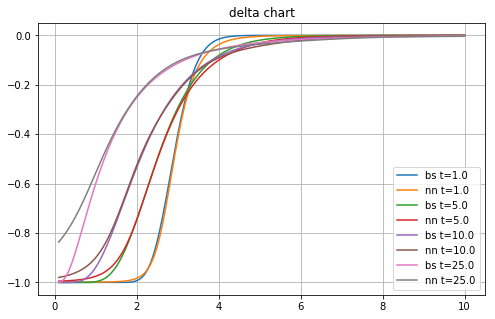

In [0]:
import matplotlib.pyplot as plt


plt.clf()
plt.cla()
plt.close()
plt.figure(figsize=(8,5))
plt.grid(True)

tl=[1.0,5.0,10.0,25.0]
for tc in tl:
  sc=torch.linspace(0.1,10,200,device=device)
  tsvc=torch.zeros((200,3),device=device)
  tsvc[:,0]=tc
  tsvc[:,1]=sc
  tsvc[:,2]= 0.1476
  d_bs=delta_bs(sc.cpu().numpy(),3.,rf,0,tc,vol)-1
  d_nn=-model_delta(tsvc)
  plt.plot(sc.cpu().numpy(),d_bs,label="bs t="+ "%.1f" % tc)
  plt.plot(sc.cpu().numpy(),d_nn.cpu().view(200).detach().numpy(),
           label="nn t="+ "%.1f" % tc)



plt.title("delta chart")
plt.legend()
#plt.savefig("test.svg")
plt.show()

The delta chart from the delta neural network actually matches up with the Black-Scholes delta relatively well. The volatility assumption for the Black-Scholes delta is based on the variance of log(index_25) distribution. At lower strike, the neural network tend to have slight smaller(more positive) delta. This is consistent with how AAA equity scenario is calibrated. AAA scenario got fatter tails compared to lognormal. 

In [0]:
def cte98(e):
  e=e.reshape(-1)
  n=e.size()[0]
  k=math.ceil(n*0.02)
  l2=e.topk(k,sorted=False).values.mean()
  return l2

def cte70(e):
  e=e.reshape(-1)
  n=e.size()[0]
  k=math.ceil(n*0.3)
  l2=e.topk(k,sorted=False).values.mean()
  return l2  

In [0]:
def print_stat():
  #need delta, gamma, chg, chg2 and pv_payout global variable 
  delta_gl=torch.sum(delta*chg,dim=2)
  gamma_gl=torch.sum(gamma*chg2,dim=2)

  pre_hedge=pv_payout.std().item()
  post_hedge=(delta_gl+gamma_gl-pv_payout).std().item()

  print("\n% scenario with payout: ",pv_payout.sign().mean().item())

  print("\nstd pv payout, after hedge, effectiveness")
  print("{:.3%}".format(pre_hedge), "{:.3%}".format(post_hedge), \
        "{:.3%}".format(1-post_hedge/pre_hedge))

  print("\nAverage, before and after hedge:")
  print("{:.3%}".format(pv_payout.mean().item()))
  print("{:.3%}".format((pv_payout-gamma_gl-delta_gl).mean().item()))

  print("\nCTE 70, before and after hedge:")
  print("{:.3%}".format(cte70(pv_payout).item()))
  print("{:.3%}".format(cte70(pv_payout-gamma_gl-delta_gl).item()))

  print("\nCTE 98, before and after hedge:")
  print("{:.3%}".format(cte98(pv_payout).item()))
  print("{:.3%}".format(cte98(pv_payout-gamma_gl-delta_gl).item()))

Now calculate stats of the hedging result

In [0]:
delta=model_delta(tsv)
delta=-delta.view(N1,N2,T)

g = torch.ones_like(delta)
gamma, =grad(delta,tsv,grad_outputs=g,create_graph=True)      
gamma=gamma[:,:,:,1].view(N1,N2,T)

print_stat()


% scenario with payout:  0.1656494140625

std pv payout, after hedge, effectiveness
22.192% 3.503% 84.216%

Average, before and after hedge:
7.887%
74.646%

CTE 70, before and after hedge:
26.285%
78.576%

CTE 98, before and after hedge:
107.910%
85.849%


The hedge effectiveness is around 85%. 

The average after hedge is essentially a risk free price of the option. It is a lot higher compared to the unhedged average which is real world.

The CTE 70 is worse compared to unhedged case. This is expected since the CTE 70 grows faster than risk free rate. 

CTE98 actually improved from 1.1 to around 0.85 mostly because 2 percentile of the AAA scenario return grow at a slower rate compared to risk free rate. 



### Add CTE98 as training target

The framework is flexible enough we can actually incorporate CTE 98 as a training target directly. 

CTE 70 doesn't work very well as a training target. The model will ask us to stop hedging completely since 30th percentile of the scenario grows too fast compared to risk free rate.

In [0]:
cte_delta = torch.nn.Sequential(
    torch.nn.Linear(3, 24),
    torch.nn.Tanh(),
    torch.nn.Linear(24,12),
    torch.nn.Tanh(),
    torch.nn.Linear(12, 1),
    torch.nn.Sigmoid(),
)
cte_delta = cte_delta.to(device)

When using CTE98 target directly, the weight update will be calculated based on only a small set of scenarios. And the training speed is slower. So we first train the network with the std target with AdamW for a little bit. Then shift to the CTE 98 target with LBFGS

In [0]:
import time
optimizer = torch.optim.AdamW(cte_delta.parameters(),lr=0.03,
                              weight_decay=1e-10,amsgrad=True)
t1=time.time()
for j in range(30):
    for i in range(N1):
        optimizer.zero_grad()
        tsvi=tsv[i]
        delta=-cte_delta(tsvi)
# gamma is used to approximate the daily rebalance g/l
        g = torch.ones_like(delta)
        gamma, =grad(delta,tsvi,grad_outputs=g,create_graph=True)   

        delta=delta.view(N2,T)
        gamma=gamma[:,:,1].view(N2,T)
        delta_gl=torch.sum(delta*chg[i],dim=1)
        gamma_gl=torch.sum(gamma*chg2[i],dim=1)

        hedged_price=pv_payout[i]-delta_gl-gamma_gl
      
        loss=hedged_price.std()
        loss.backward()
        optimizer.step()    
    if j%10==0: print(j,loss.item())
    t2=time.time()
    if t2-t1> 180:
      break
print("{:.3}".format(t2-t1), " seconds")  

0 0.21814580261707306
10 0.046338267624378204
20 0.048721086233854294
7.55  seconds


In [0]:
optimizer = torch.optim.LBFGS(cte_delta.parameters(),lr=1.0,
                             max_iter=150,line_search_fn ="strong_wolfe",
                             tolerance_grad=1e-30, tolerance_change=1e-30)
def closure():
  optimizer.zero_grad()
  delta=-cte_delta(tsv)
  delta=delta.view(N1,N2,T)
  # gamma is used to approximate the daily rebalance g/l
  g = torch.ones_like(delta)
  gamma, =grad(delta,tsv,grad_outputs=g,create_graph=True)   
  gamma=gamma[:,:,:,1].view(N1,N2,T)
  delta_gl=torch.sum(delta*chg,dim=2)
  gamma_gl=torch.sum(gamma*chg2,dim=2)
  hedged_price=pv_payout-delta_gl-gamma_gl
  loss=cte98(hedged_price)
  loss.backward()  
  return loss

t1=time.time()
print("init",closure().item())
optimizer.step(closure)
print("lbfgs",closure().item())
t2=time.time()
print("{:.3}".format(t2-t1), " seconds")

init 0.9288612604141235
lbfgs 0.8075775504112244
29.6  seconds


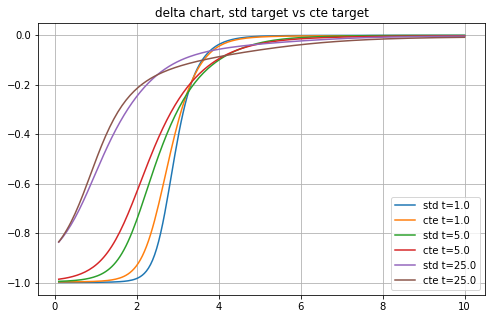

In [0]:
import matplotlib.pyplot as plt


plt.clf()
plt.cla()
plt.close()
plt.figure(figsize=(8,5))
plt.grid(True)

tl=[1,5.0,25.0]
for tc in tl:
  sc=torch.linspace(0.1,10,200,device=device)
  tsvc=torch.zeros((200,3),device=device)
  tsvc[:,0]=tc
  tsvc[:,1]=sc
  tsvc[:,2]= 0.1476
  d_cte=-cte_delta(tsvc)
  d_nn=-model_delta(tsvc)

  plt.plot(sc.cpu().numpy(),d_nn.cpu().view(200).detach().numpy(),
           label="std t="+ "%.1f" % tc)

  plt.plot(sc.cpu().numpy(),d_cte.cpu().view(200).detach().numpy(),
           label="cte t="+ "%.1f" % tc)


plt.title("delta chart, std target vs cte target")
plt.legend()
#plt.savefig("test.svg")
plt.show()

After using CTE as traning target, the delta is smaller(more positive) compared to previous model. This is to take advantage of the build in upward drift of the AAA scenario. It's interesting that the slope of delta curve(gamma) could change direction for very low index levels if there are size of the delta network is bigger. “Be fearful when others are greedy and greedy when others are fearful.” :)

In [0]:
delta=cte_delta(tsv)
delta=-delta.view(N1,N2,T)

g = torch.ones_like(delta)
gamma, =grad(delta,tsv,grad_outputs=g,create_graph=True)      
gamma=gamma[:,:,:,1].view(N1,N2,T)

print_stat()


% scenario with payout:  0.1656494140625

std pv payout, after hedge, effectiveness
22.192% 4.991% 77.510%

Average, before and after hedge:
7.887%
66.701%

CTE 70, before and after hedge:
26.285%
72.680%

CTE 98, before and after hedge:
107.910%
80.758%


The hedge effectiveness decreased as expected. But the CTE98 further improved to around 0.81 compared to std target

### Trade off between CTE70 and CTE98


We can  use a weight average of CTE70 and CTE98 as target. This way we are optimizing for both captial and reserve

First pretrain a model with std target and with AdamW

In [0]:
cte_delta = torch.nn.Sequential(
    torch.nn.Linear(3, 24),
    torch.nn.Tanh(),
    torch.nn.Linear(24,12),
    torch.nn.Tanh(),
    torch.nn.Linear(12, 1),
    torch.nn.Sigmoid(),
)
cte_delta = cte_delta.to(device)

optimizer = torch.optim.AdamW(cte_delta.parameters(),lr=0.03,
                              weight_decay=1e-10,amsgrad=True)
t1=time.time()
for j in range(30):
  for i in range(N1):
    optimizer.zero_grad()
    tsvi=tsv[i]
    delta=-cte_delta(tsvi)
# gamma is used to approximate the daily rebalance g/l
    g = torch.ones_like(delta)
    gamma, =grad(delta,tsvi,grad_outputs=g,create_graph=True)   

    delta=delta.view(N2,T)
    gamma=gamma[:,:,1].view(N2,T)
    delta_gl=torch.sum(delta*chg[i],dim=1)
    gamma_gl=torch.sum(gamma*chg2[i],dim=1)

    hedged_price=pv_payout[i]-delta_gl-gamma_gl
  
    loss=hedged_price.std()
    loss.backward()
    optimizer.step()    


Next, clone the pretrained model. use different split between cte70 and cte98 to train

In [0]:
import copy
import numpy as np
c70=np.zeros(11)
c98=np.zeros(11)
avg_after=np.zeros(11)
he=np.zeros(11)
alphas=np.array([.60,.61,.62,.63,.64,.65,.68,.7,.75,.8,1.0])
for i in range(11):
  print(i)
  alpha=alphas[i]
  cte_delta2=copy.deepcopy(cte_delta)
  optimizer = torch.optim.LBFGS(cte_delta2.parameters(),lr=1.0,
                              max_iter=150,line_search_fn ="strong_wolfe",
                              tolerance_grad=1e-30, tolerance_change=1e-30)
  def closure():
    optimizer.zero_grad()
    delta=-cte_delta2(tsv)
    delta=delta.view(N1,N2,T)
    # gamma is used to approximate the daily rebalance g/l
    g = torch.ones_like(delta)
    gamma, =grad(delta,tsv,grad_outputs=g,create_graph=True)   
    gamma=gamma[:,:,:,1].view(N1,N2,T)
    delta_gl=torch.sum(delta*chg,dim=2)
    gamma_gl=torch.sum(gamma*chg2,dim=2)
    hedged_price=pv_payout-delta_gl-gamma_gl
    loss=cte98(hedged_price)*(alpha)+cte70(hedged_price)*(1-alpha)
    loss.backward()  
    return loss
  optimizer.step(closure)


  delta=-cte_delta2(tsv)
  delta=delta.view(N1,N2,T)
  # gamma is used to approximate the daily rebalance g/l
  g = torch.ones_like(delta)
  gamma, =grad(delta,tsv,grad_outputs=g,create_graph=True)   
  gamma=gamma[:,:,:,1].view(N1,N2,T)
  delta_gl=torch.sum(delta*chg,dim=2)
  gamma_gl=torch.sum(gamma*chg2,dim=2)
  hedged_price=pv_payout-delta_gl-gamma_gl    
  avg_after[i]=hedged_price.mean().item()
  pre_hedge=pv_payout.std().item()
  post_hedge=(delta_gl+gamma_gl-pv_payout).std().item()
  he[i]=1-post_hedge/pre_hedge
  c98[i]=cte98(hedged_price)
  c70[i]=cte70(hedged_price)

  

0
1
2
3
4
5
6
7
8
9
10


[-0.020264   -0.01903369 -0.01845026 -0.0406756   0.14548225  0.18868831
  0.28440036  0.52881972  0.64858668  0.70732456  0.77567588]


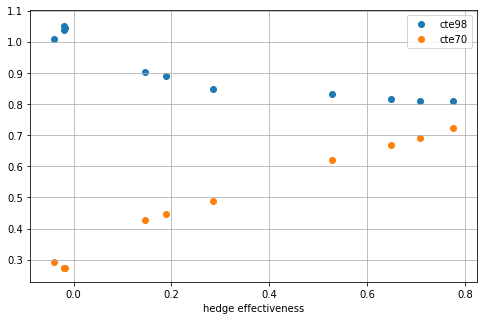

In [0]:
plt.clf()
plt.cla()
plt.close()
plt.figure(figsize=(8,5))
plt.grid(True)
plt.scatter(he,c98,label="cte98")
plt.scatter(he,c70,label="cte70")
plt.xlabel("hedge effectiveness")
plt.legend()



## Conclusion 
We demostrated 

* How to hedge under AAA scenario. 

* A second order approximation for daily rebalance is needed to gain high hedge effectiveness. Monthly rebalance is not good enough

* How to hedge to CTE98 target. 
Train on std target for a little bit. Then switch to CTE98 target. It is also possible to use a blend CTE98 and CTE70 target to train. 